In [3]:
!pip install tensorflow==2.10.0 opencv-python mediapipe scikit-learn matplotlib


  Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl.metadata (806 bytes)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
  Using cached mediapipe-0.10.20-cp310-cp310-win_amd64.whl.metadata (9.9 kB)
  Using cached mediapipe-0.10.18-cp310-cp310-win_amd64.whl.metadata (9.9 kB)
  Using cached mediapipe-0.10.13-cp310-cp310-win_amd64.whl.metadata (9.9 kB)
  Using cached mediapipe-0.10.11-cp310-cp310-win_amd64.whl.metadata (9.8 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\jayanth\\anaconda3\\lib\\site-packages\\tensorboard_data_server-0.6.1.dist-info\\METADATA'



In [15]:
!pip install protobuf==3.20.*


   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 904.0/904.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires tensorboard-data-server<0.7.0,>=0.6.0, which is not installed.
tensorflow-intel 2.18.0 requires keras>=3.5.0, which is not installed.
mediapipe 0.10.14 requires protobuf<5,>=4.25.3, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.10.1 which is incompatible.


In [5]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [7]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
def draw_styled_landmarks(image, results):
    # Draw face connections (use face_landmarks directly, not FACE_CONNECTIONS)
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,  # use FACEMESH_TESSELATION for face
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        ) 

    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        ) 

    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        ) 

    # Draw right hand connections  
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )


In [9]:

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [11]:
import os
import numpy as np

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('sign_lang_Data')

# Actions that we try to detect
actions = np.array(['hello', 'thanks','I love you'])

# Create action directories if they don't exist
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path):
        os.makedirs(action_path)

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder =1


In [11]:

for action in actions: 
    action_path = os.path.join(DATA_PATH, action)
    
    # Check if the action directory exists
    if os.path.exists(action_path):
        # Get list of existing directories
        existing_dirs = os.listdir(action_path)
        # Filter out non-integer directory names
        existing_dirs = [int(d) for d in existing_dirs if d.isdigit()]
        
        # Check if there are any existing directories
        if existing_dirs:
            dirmax = np.max(existing_dirs)
        else:
            dirmax = 0  # If no directories exist, start from 0
    else:
        dirmax = 0  # If action directory doesn't exist, start from 0
    
    # Create new directories for sequences
    for sequence in range(1, no_sequences + 1):
        try: 
            os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
        except FileExistsError:
            pass  # Ignore if the directory already exists


NameError: name 'actions' is not defined

In [15]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()
                frame = cv2.flip(frame, 1)

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow.keras'

In [15]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'I love you': 2}

In [19]:

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [21]:

X = np.array(sequences)
X.shape

(90, 30, 1662)

In [23]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(5, 3)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

C:\Users\Jayanth\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - categorical_accuracy: 0.3445 - loss: 1.0951
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.2485 - loss: 8.1631
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.3933 - loss: 7.2066
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.3954 - loss: 11.5651
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_accuracy: 0.3523 - loss: 17.9129
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.2975 - loss: 7.9444
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.2935 - loss: 13.9356
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.3072 - loss: 40.8166
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_accuracy: 0.4050 - loss: 31.4872
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - categorical_accuracy: 0.2095 - loss: 63.2812
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━

In [33]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


In [35]:
actions[np.argmax(y_test[2])]

'I love you'

In [37]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[[2, 2],
        [0, 1]],

       [[3, 0],
        [2, 0]],

       [[2, 1],
        [1, 1]]], dtype=int64)

In [39]:

accuracy_score(ytrue, yhat)

0.4

In [41]:
from scipy import stats

In [ ]:

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

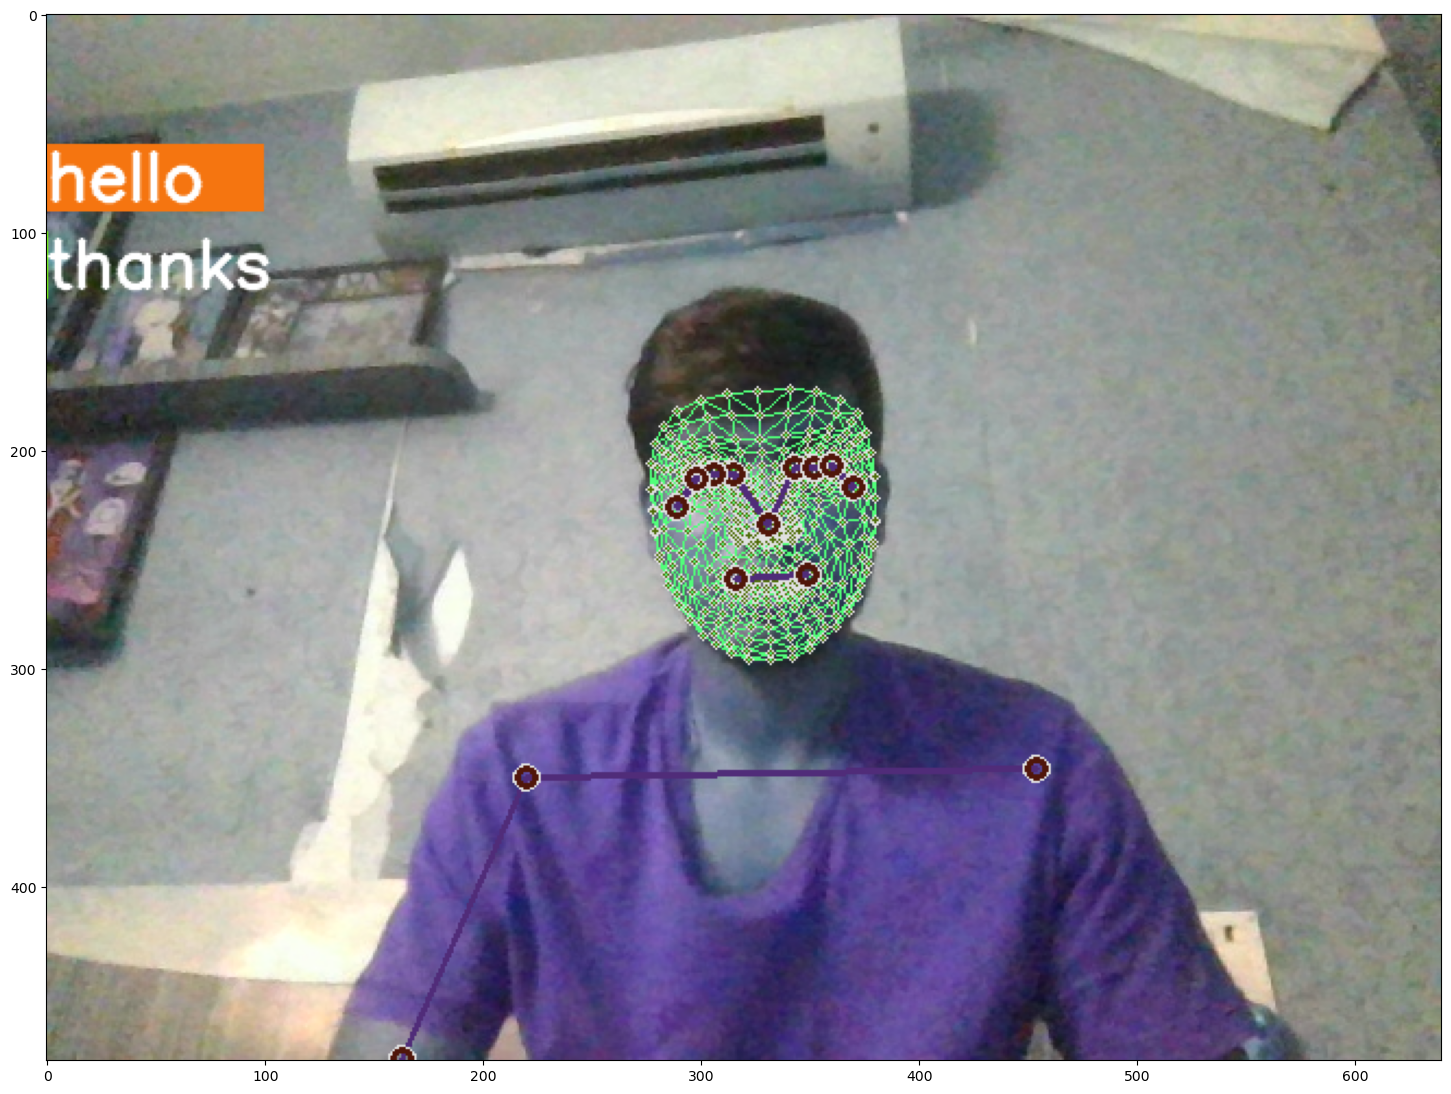

In [51]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [59]:

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti